# Production éolienne

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import date, datetime, timezone

## Chargement des données
- prod_eolienne.csv

In [2]:
df = pd.read_csv('/home/gaetansimplon/production_enr/data/prod_eolienne.csv')
display(df.dtypes)
display(df)


date              object
prod_eolienne    float64
dtype: object

,date,prod_eolienne
0,2016-09-01,100.000000
1,2016-09-02,100.000000
2,2016-09-03,100.000000
3,2016-09-04,96.844120
4,2016-09-05,97.088424
...,...,...
3303,2025-09-25,72.259819
3304,2025-09-26,52.211649
3305,2025-09-27,38.421115
3306,2025-09-28,55.810392


## En résumé
- 3308 entrées
- 2 colonnes 


In [3]:
display(df.dtypes)
display(df.describe())


date              object
prod_eolienne    float64
dtype: object

,prod_eolienne
count,3308.000000
mean,60.261740
std,27.466505
min,-48.997601
25%,44.321585
50%,61.730794
75%,76.859869
max,833.516984


### Valeurs manquantes et aberrantes

In [4]:
# Valeurs manquantes
df_missing = df.isnull().sum()
display(df_missing)

# Valeur extrême

df_weird = df.sort_values(by=['prod_eolienne'], ascending=True)
display(min(df_weird['prod_eolienne']))
display(df_weird)

df_max = df.sort_values(by=['prod_eolienne'], ascending=False)

print(df_max)

date             0
prod_eolienne    0
dtype: int64

-48.99760076569133

,date,prod_eolienne
2794,2024-05-04,-48.997601
2354,2023-02-19,7.077903
3262,2025-08-15,7.656243
2353,2023-02-18,8.626531
3261,2025-08-14,9.223880
...,...,...
1041,2019-07-17,100.000000
1043,2019-07-19,100.000000
1275,2020-03-07,100.000000
1014,2019-06-19,666.206615


            date  prod_eolienne
1002  2019-06-07     833.516984
1014  2019-06-19     666.206615
578   2018-04-07     100.000000
0     2016-09-01     100.000000
583   2018-04-12     100.000000
...          ...            ...
3261  2025-08-14       9.223880
2353  2023-02-18       8.626531
3262  2025-08-15       7.656243
2354  2023-02-19       7.077903
2794  2024-05-04     -48.997601

[3308 rows x 2 columns]


### Traitement des valeurs aberrantes
- Si valeur < 0 -> passage à une valeur absolue
- Si valeur > 100 -> passage à une valeur  NULL

In [5]:
# Fonction pour traiter les valeurs aberrantes

def clean_value(number):
    if number < 0:
        number = abs(number)
    if number > 100:
        return None
    return number

df['prod_eolienne'] = df['prod_eolienne'].apply(clean_value)
df = df.dropna()

display(df.isnull().sum())
display(df.describe())
display(df.sort_values(by=['prod_eolienne']))

date             0
prod_eolienne    0
dtype: int64

,prod_eolienne
count,3306.000000
mean,59.874200
std,21.427358
min,7.077903
25%,44.331044
50%,61.704084
75%,76.830423
max,100.000000


,date,prod_eolienne
2354,2023-02-19,7.077903
3262,2025-08-15,7.656243
2353,2023-02-18,8.626531
3261,2025-08-14,9.223880
3036,2025-01-01,9.357384
...,...,...
1987,2022-02-17,100.000000
1607,2021-02-02,100.000000
1905,2021-11-27,100.000000
1,2016-09-02,100.000000


### Conversion de la colonne 'date' au format datetime

In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

display(df.dtypes)

/tmp/ipykernel_44113/1996876030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


date             datetime64[ns]
prod_eolienne           float64
dtype: object

# Paramètres influençant la production éolienne
- Vitesse moyenne du vent (10m)
- Direction du vent
- Température
- Pression atmosphérique (niveau de la mer)

Données récoltées depuis l'API open-meteo

In [7]:
# Chargement
df_param = pd.read_csv('/home/gaetansimplon/production_enr/data/param_eolienne.csv')


# Mise au format datetime
df_param['time'] = pd.to_datetime(df_param['time'])
# Renommage colonne date (time -> date)
df_param.rename(columns={'time': 'date'}, inplace=True)

print(df_param)

           date  winddirection_10m_dominant (°)  wind_speed_10m_mean (km/h)  \
0    2016-09-01                             269                        12.0   
1    2016-09-02                             234                        12.6   
2    2016-09-03                             237                        11.5   
3    2016-09-04                             270                        11.6   
4    2016-09-05                             307                        17.6   
...         ...                             ...                         ...   
3312 2025-09-26                             306                         6.4   
3313 2025-09-27                             355                         6.3   
3314 2025-09-28                               2                         5.4   
3315 2025-09-29                             340                         4.4   
3316 2025-09-30                             357                         7.3   

      temperature_2m_mean (°C)  pressure_msl_mean (

In [8]:
# Résumé
display('Résumé : ',df_param.describe())

# Types de données

display('Types des données : ',df_param.dtypes)

## Missing values

display('Valeurs manquantes : ', df_param.isnull().sum())

## Doublons

display('Doublons :', df_param.duplicated().sum())

'Résumé : '

,date,winddirection_10m_dominant (°),wind_speed_10m_mean (km/h),temperature_2m_mean (°C),pressure_msl_mean (hPa)
count,3317,3317.000000,3317.000000,3317.000000,3317.000000
mean,2021-03-17 00:00:00,214.220380,12.146367,15.574977,1016.976485
min,2016-09-01 00:00:00,0.000000,3.500000,-2.200000,987.900000
25%,2018-12-09 00:00:00,113.000000,8.600000,10.000000,1013.300000
50%,2021-03-17 00:00:00,268.000000,10.900000,15.000000,1016.700000
75%,2023-06-24 00:00:00,316.000000,14.700000,21.400000,1020.800000
max,2025-09-30 00:00:00,360.000000,43.100000,33.600000,1038.400000
std,NaN,119.203858,4.924862,6.928749,6.927902


'Types des données : '

date                              datetime64[ns]
winddirection_10m_dominant (°)             int64
wind_speed_10m_mean (km/h)               float64
temperature_2m_mean (°C)                 float64
pressure_msl_mean (hPa)                  float64
dtype: object

'Valeurs manquantes : '

date                              0
winddirection_10m_dominant (°)    0
wind_speed_10m_mean (km/h)        0
temperature_2m_mean (°C)          0
pressure_msl_mean (hPa)           0
dtype: int64

'Doublons :'

np.int64(0)

## Feature Engineering


### Encodage des données de direction du vent

- Afin de signifier l'aspect 'circulaire' de ce type de données, il est nécessaire d'encoder ces dernières.
- Transformer une valeur d'angle en deux valeurs : sin (nord-sud) et cos (est-ouest)
- Ces deux nouvelles valeurs seront des features indépendantes pour l'entrainement du modèle

### Saisonalité

- Prise en compte des mois de l'année et des saisons

### Traitement de la vitesse du vent 

- La puissance du vent dépend du cube de la vitesse du vent, il faut donc en rendre compte dans nos données

### Interactions entre les données

- Vitesse du vent x Direction du vent (wind_speed*wind_dir_sin | wind_dir_cos)
- Température x Pression

### Standardisation des données

- Certains modèles nécessitent d'avoir des données normalisées/standardisées

In [9]:
# Mise en fonction de la conversion de la direction du vent

def convert_wind_dir(df: pd.DataFrame, col_name: str='winddirection_10m_dominant (°)') -> pd.DataFrame:
    """
    Encode une colonne d'angle en degrés (0-360) sous forme trigonométrique (sin, cos).
    
    Args:
        df (pd.DataFrame): DataFrame contenant la colonne d'angle en degrés.
        col_name (str): Nom de la colonne contenant la direction du vent en degrés.
    
    Returns:
        pd.DataFrame: DataFrame avec deux nouvelles colonnes ('wind_dir_sin', 'wind_dir_cos'),
                      et sans la colonne d'origine en degrés ni sa version en radians.
    """
    df = df.copy()
    # renommage
    df = df.rename(columns={col_name: 'wind_direction'})
    # conversion en radians
    df['wind_direction_rad'] = np.deg2rad(df['wind_direction'])
    # encodage trigo
    df['wind_dir_sin'] = np.sin(df['wind_direction_rad'])
    df['wind_dir_cos'] = np.cos(df['wind_direction_rad'])
    # suppression colonnes précédentes
    df = df.drop(columns=['wind_direction', 'wind_direction_rad'])
    return df
    

    

### Encodage de variables temporelle

- Création d'une variable 'mois' pour enrichir le nombre de variable d'entrainement

In [10]:

def convert_date_to_month(df: pd.DataFrame, col_name: str='date') -> pd.DataFrame:
    """
    Convertit la colonne 'date' au format datetime
    """
    df = df.copy()
    # Conversion en datetime
    df[col_name] = pd.to_datetime(df[col_name])
    # Création de la variable month
    df['month'] = df[col_name].dt.month
    return df

## Traitement de la variable de vitesse du vent

- **wind_speed2**: la puissance du vent dépend du cube de la vitesse, la vitesse au carré rend compte de la courbure que forme la relation entre puissance du vent et vitesse du vent

- **wind_speed3**: Rend compte de la relation concrète et physique exacte entre le vent et la puissance

- **wind_cos/sin**: Intègre la direction du vent dans la force effective qui agit sur l'éolienne

- **temp_press**: Rend compte de l'interaction entre la température et la pression pour donner une valeur approximative de la densité de l'air. La densité de l'air influence la puissance du vent (variable wind_speed3)

In [11]:
def compute_wind_param(df: pd.DataFrame) -> pd.DataFrame:
    """Ajoute les features dérivées pour la production éolienne :
    - wind_speed^2, wind_speed^3
    - composantes cos et sin de la vitesse du vent selon la direction
    - interaction température * pression

    """
    df = df.copy()
    
    # Puissance du vent
    df['wind_speed2'] = df['wind_speed_10m_mean (km/h)']**2
    df['wind_speed3'] = df['wind_speed_10m_mean (km/h)']**3
    
    # Composantes selon direction
    
    df['wind_cos'] = df['wind_speed_10m_mean (km/h)'] * df['wind_dir_cos']
    df['wind_sin'] = df['wind_speed_10m_mean (km/h)'] * df['wind_dir_sin']
    
    # Interaction température * pression
    
    df['temp_press'] = (df['temperature_2m_mean (°C)'] * df['pressure_msl_mean (hPa)'])
    
    return df
    
    

In [12]:
from sklearn.preprocessing import StandardScaler

def standardize_features(df: pd.DataFrame, cols_to_scale: list[str]) -> pd.DataFrame:
    """
    Standardise les colonnes sélectionnées
    """
    
    df = df.copy()
    
    scaler = StandardScaler()
    
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    return df    

## Comparaison des dataframes
- En vue d'une fusion, on vérifie les correspondances au niveau des dates
- Le but étant d'avoir un dataframe ayant le label/target et les variables qui seront utilisées pour l'entrainement d'un modèle

In [13]:
## Comparaison des 2 dataframes

# Suppresion de la date en trop (2025-09-30)
df_param = df_param[df_param['date'] != pd.to_datetime("2025-09-30")]

display('Prod : ',df['date'].min(), df['date'].max())
display('Météo : ',df_param['date'].min(), df_param['date'].max())

## Verif des doublons 

display(df['date'].nunique())
display(df_param['date'].nunique())

'Prod : '

Timestamp('2016-09-01 00:00:00')

Timestamp('2025-09-29 00:00:00')

'Météo : '

Timestamp('2016-09-01 00:00:00')

Timestamp('2025-09-29 00:00:00')

3306

3316

In [14]:
## Recherches des dates sans correspondances
date_diff = set(df_param['date']) - set(df['date'])
display(sorted(list(date_diff)))

[Timestamp('2016-09-22 00:00:00'),
 Timestamp('2016-09-23 00:00:00'),
 Timestamp('2016-09-24 00:00:00'),
 Timestamp('2016-09-25 00:00:00'),
 Timestamp('2017-05-17 00:00:00'),
 Timestamp('2018-04-15 00:00:00'),
 Timestamp('2018-04-16 00:00:00'),
 Timestamp('2019-06-07 00:00:00'),
 Timestamp('2019-06-19 00:00:00'),
 Timestamp('2019-06-23 00:00:00')]

In [20]:
## Fusion des dataframes

df_merged = pd.merge(
    df, df_param,
    on='date', how='inner'
)

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline de prétraitement des données météo
    """
    # Conversion date -> datetime
    df = convert_date_to_month(df)
    # Conversion variable direction du vent (degré -> sin/cos)
    df = convert_wind_dir(df)
    # Mise en relation des données sur la puissance/vitesse du vent et pression * température
    df = compute_wind_param(df)
    # Sélection des colonnes à standardiser
    cols_to_scale = [
        'temperature_2m_mean (°C)',
        'pressure_msl_mean (hPa)',
        'wind_speed_10m_mean (km/h)',
        'wind_speed2',
        'wind_speed3',
        'wind_cos',
        'wind_sin',
        'temp_press'  
    ]
    
    df = standardize_features(df, cols_to_scale)
    
    return df

df_merged = preprocess_data(df_merged)

## Classe - Fonctions spécifiques
### Traitement & Nettoyage
- Encoder les valeurs de direction du vent sous forme trigonométrique (sin pour les directions nord-sud et cos pour les directions est-ouest) 
- Valeur de production située dans l'intervalle [0, 100] (nettoyage)
- Encoder les dates (object -> datetime)
- Optionnel: créer une variable de mois pour créer une variable temporelle pertinente
### Sauvegarde dans BDD
- Doit contenir la date (datetime), production_eolienne, vitesse moyenne du vent, direction du vent sin (nord-sud), direction du vent cos (est-ouest), pression atmosphérique et température 

In [21]:
display(df_merged.columns)

Index(['date', 'prod_eolienne', 'wind_speed_10m_mean (km/h)',
       'temperature_2m_mean (°C)', 'pressure_msl_mean (hPa)', 'month',
       'wind_dir_sin', 'wind_dir_cos', 'wind_speed2', 'wind_speed3',
       'wind_cos', 'wind_sin', 'temp_press'],
      dtype='object')

# Entrainement

## Linear Regression


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

model = LinearRegression()

features = ['wind_speed_10m_mean (km/h)', 'temperature_2m_mean (°C)', 'pressure_msl_mean (hPa)','wind_dir_sin', 'wind_dir_cos', 'month']
X = df_merged[features]
y = df_merged['prod_eolienne']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

display('R2-score :', r2_score(y_test, y_pred))
display('Mean Absolute Error : ', mean_absolute_error(y_test, y_pred))
display('Mean Squared Error : ', mean_squared_error(y_test, y_pred))

KeyError: "['wind_dir_sin', 'wind_dir_cos', 'month'] not in index"

## Ridge

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)


print("R2score : ", r2)
print("Mean Absolute Error : ", mae)
print("Mean Squared Error : ", mse)

# Recherche du meilleur paramètre alpha 

alphas = [0.01, 0.1, 1, 10, 100]

ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

ridge_cv.fit(X_train, y_train)

display('Meilleur param : ', ridge_cv.alpha_)

# Test avec les meilleurs params alpha

ridge = Ridge(alpha=10)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

r2_best = r2_score(y_test, y_pred)
mae_best = mean_absolute_error(y_test, y_pred)
mse_best = mean_squared_error(y_test, y_pred)

print("R2score : ", r2_best)
print("Mean Absolute Error : ", mae_best)
print("Mean Squared Error : ", mse_best)

R2score :  0.26757252328046244
Mean Absolute Error :  14.766095429830429
Mean Squared Error :  332.150064998786


'Meilleur param : '

np.float64(10.0)

R2score :  0.26755226608352634
Mean Absolute Error :  14.766365143359996
Mean Squared Error :  332.1592514773015


In [ ]:
# Standardisation des données
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.1, 1, 10, 100]
ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
)
ridge_cv.fit(X_train, y_train)

y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

print("R2 train :", r2_score(y_train, y_train_pred))
print("R2 test  :", r2_score(y_test, y_test_pred))

R2 train : 0.3106859796408431
R2 test  : 0.26774218638682756


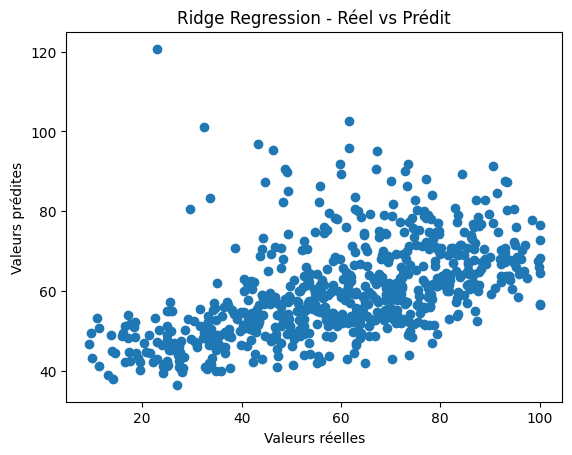

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Ridge Regression - Réel vs Prédit")
plt.show()
